# TRAFFIC SIGNALS

In [418]:
# IMPORTS
import tensorflow as tf
import numpy as np
from skimage import transform
import os
from skimage.color import rgb2gray
import skimage.data as imd
import matplotlib.pyplot as plt
import random
from tensorflow.python.framework import ops

In [419]:
tf.__version__

'1.13.1'

In [420]:
ops.reset_default_graph()
sess = tf.Session()

Define a function to load the data, and do a little EDA

In [421]:
def load_ml_data(data_directory):
    dirs = [d for d in os.listdir(data_directory)
            if os.path.isdir(os.path.join(data_directory, d))]

    labels = []
    images = []

    # ahora vamos a las imagenes
    for d in dirs:
        label_dir = os.path.join(data_directory, d)
        file_names = [os.path.join(label_dir, f)
                      for f in os.listdir(label_dir)
                      if f.endswith('.ppm')]

        for f in file_names:
            images.append(imd.imread(f))
            labels.append(int(d))
    images = np.array(images)
    labels = np.array(labels)
    return images, labels

## 1. EDA

In [422]:
images_train, labels_train = load_ml_data('BelgiumTSC_Training/Training')
images_test, labels_test = load_ml_data('BelgiumTSC_Testing/Testing')
print('Number of images:', images_train.size)
print('Number of labels:', labels_train.size)
print('Number of distinc traffic signals:', len(set(labels_train)))

Number of images: 4575
Number of labels: 4575
Number of distinc traffic signals: 62


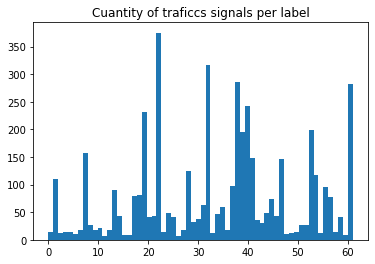

In [423]:
plt.title('Cuantity of traficcs signals per label')
plt.hist(labels_train, len(set(labels_train)))
pass

In [424]:
rand_signals = random.sample(range(0, len(labels_train)), 10)
rand_signals

[719, 3621, 3232, 593, 2813, 71, 3815, 4199, 3860, 2065]

In [425]:
#Print some images
def rand_signals_plot(array, number_sample, color='jet'):
    '''
    To represent random traffic signals
    :param array: an array with the traffic signals images
    :param number_sample: number of samples to plot
    :param color: the color to show the images, default is RGB, but you can choose gray or another
    :return: a plot of sample traffic signals from your dataset
    '''
    rand_signals = random.sample(range(0, len(array)), number_sample)
    for n in range(number_sample):
        plt.figure(figsize=(14,10))
        temp_img = array[rand_signals[n]]
        plt.subplot(1, 10, n+1)
        plt.axis('off')
        plt.imshow(temp_img, cmap=color)
        plt.show()
        print('image structure:{}'.format(temp_img.shape))

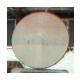

image structure:(134, 135, 3)


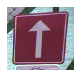

image structure:(220, 231, 3)


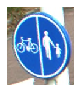

image structure:(129, 110, 3)


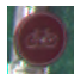

image structure:(57, 56, 3)


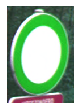

image structure:(172, 118, 3)


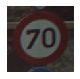

image structure:(99, 100, 3)


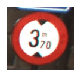

image structure:(106, 112, 3)


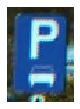

image structure:(69, 48, 3)


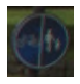

image structure:(68, 64, 3)


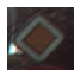

image structure:(53, 56, 3)


In [426]:
rand_signals_plot(images_train, 10)

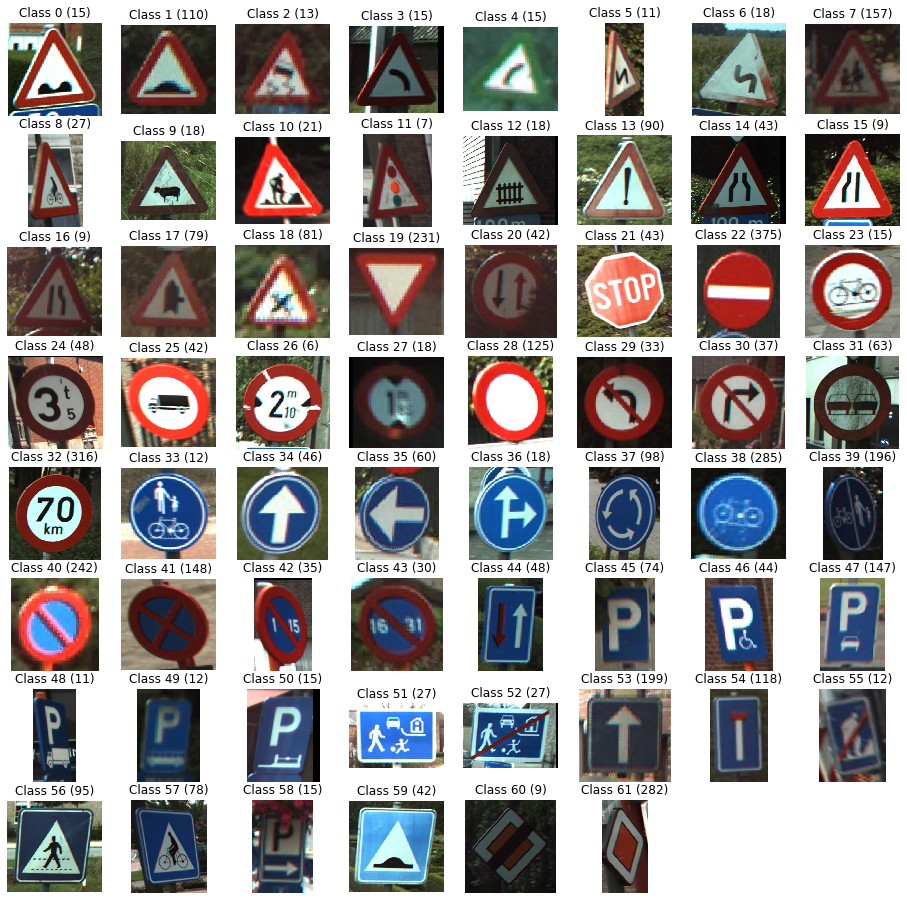

In [427]:
#Show all distinct images
unique_labels = set(labels_train)
plt.figure(figsize=(16,16))
i = 1
for label in unique_labels:
    temp_im = images_train[list(labels_train).index(label)]
    plt.subplot(8,8, i)
    plt.axis("off")
    plt.title("Class {0} ({1})".format(label, list(labels_train).count(label)))
    i +=1
    plt.imshow(temp_im)
pass

In [428]:
w = 999
h = 999

for image in images_train:
    if image.shape[0] < h:
        h = image.shape[0]
    if image.shape[1] < w:
        w = image.shape[1]
print('Min size:{}x{}'.format(h,w))

Min size:22x20


### Conclusions
After our little EDA, we can see a few things:
1. we have 4575 images for train, and 62 signal classes.
2. We have 62 different classes of signals traffics.
3. The classes of signals traffics are unbalanced.
4. The images have different sizes.
5. There are images with good quality, and others with bad quality.
6. Some images are very small (22x20)

## 2. Preprocess
1. We need the same size for our images
2. We have to change the color of the images because we dont want that the bightness of the photo to influence our model

In [429]:
#Resize images
images_train_28 = [transform.resize(image, (28,28)) for image in images_train]
images_test_28 = [transform.resize(image, (28,28)) for image in images_test]

In [430]:
# Converto into gray scale
images_train_28 = np.array(images_train_28)
images_train_28_gray = rgb2gray(images_train_28)

images_test_28 = np.array(images_test_28)
images_test_28_gray = rgb2gray(images_test_28)

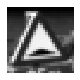

image structure:(28, 28)


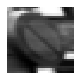

image structure:(28, 28)


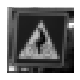

image structure:(28, 28)


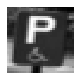

image structure:(28, 28)


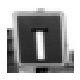

image structure:(28, 28)


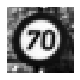

image structure:(28, 28)


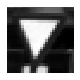

image structure:(28, 28)


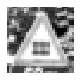

image structure:(28, 28)


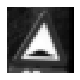

image structure:(28, 28)


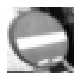

image structure:(28, 28)


In [431]:
rand_signals_plot(images_train_28_gray, 10, color='gray')

Everything is okay, so go to the next step!

## 3. Neuronal Network

We are going to:
1. Create placeholders
2. Flat the images
3. Pass the images to the first layerle pasas las imagenes aplanadas a la primera capa, de 62 unidades y activación relu
4. Create a loss function
5. Optimize the loss function
6. Predict
7. Get the accuracy

In [489]:
ops.reset_default_graph()
sess = tf.Session()

In [490]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = images_train_28_gray[0].shape[0]
image_height = images_train_28_gray[0].shape[1]
flat_image_shape = images_train_28_gray[0].shape[0]*images_train_28_gray[0].shape[1]
target_size = max(labels_train)+1
num_chanels = 1
generations = 800
eval_every = 25
full_connected_size1 = 50
full_connected_size2 = 100

In [491]:
x_input_shape = (batch_size, image_width, image_height, num_chanels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (None, image_width, image_height, num_chanels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = (evaluation_size))

In [492]:
nn_weight1 = tf.Variable(tf.truncated_normal([flat_image_shape, full_connected_size1], stddev=0.1, dtype=tf.float32))
nn_bias1 = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype = tf.float32))

nn_weight2 = tf.Variable(tf.truncated_normal([full_connected_size1, full_connected_size2], stddev=0.1, dtype=tf.float32))
nn_bias2 = tf.Variable(tf.truncated_normal([full_connected_size2], stddev=0.1, dtype=tf.float32))

nn_weight3 = tf.Variable(tf.truncated_normal([full_connected_size2, target_size], stddev=0.1, dtype=tf.float32))
nn_bias3 = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [493]:
def my_fully_connected(x_input):
    #flatten
    images_flat = tf.contrib.layers.flatten(x_input)
    
    #first hidden layer
    layer1 = tf.add(tf.matmul(images_flat, nn_weight1), nn_bias1)
    layer1 = tf.nn.relu(layer1)
    layer1 = tf.nn.dropout(layer1, 0.8)
    
    #Second hidden layer
    layer2 = tf.add(tf.matmul(layer1, nn_weight2), nn_bias2)
    layer2 = tf.nn.relu(layer2)
    layer2 = tf.nn.dropout(layer2, 0.8)
    
    #Third layer
    layer3 = tf.add(tf.matmul(layer2, nn_weight3), nn_bias3)
    
    return layer3

In [494]:
model_ouput = my_fully_connected(x_input)
test_model_output = my_fully_connected(eval_input)

In [495]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_ouput, labels = y_target))

In [496]:
prediction = tf.nn.softmax(model_ouput)
test_prediction = tf.nn.softmax(test_model_output)

In [497]:
my_optim = tf.train.AdamOptimizer(learning_rate=learning_rate)
train_step = my_optim.minimize(loss)

In [498]:
init = tf.global_variables_initializer()
sess.run(init)

In [499]:
def get_accuracy(logits, targets):
    batch_predictions = np.argmax(logits, axis = 1)
    num_corrects = np.sum(np.equal(batch_predictions, targets))
    return 100.0*num_corrects/batch_predictions.shape[0]

In [500]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []

for i in range(generations):
    rand_idx = np.random.choice(len(images_train_28_gray), size = batch_size)
    rand_x = images_train_28_gray[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = labels_train[rand_idx]
    train_dict = {x_input:rand_x, y_target:rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(images_test_28_gray), size = evaluation_size)
        rand_x_eval = images_test_28_gray[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = labels_test[rand_idx_eval]
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}
        temp_test_preds = sess.run(test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
 
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteration {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteration 25. Train Loss: 3.196. Train Acc: 24.000. Test Acc: 28.400
Iteration 50. Train Loss: 2.388. Train Acc: 40.000. Test Acc: 37.200
Iteration 75. Train Loss: 1.980. Train Acc: 44.000. Test Acc: 50.800
Iteration 100. Train Loss: 1.600. Train Acc: 56.000. Test Acc: 52.200
Iteration 125. Train Loss: 1.659. Train Acc: 51.000. Test Acc: 55.600
Iteration 150. Train Loss: 1.313. Train Acc: 58.000. Test Acc: 57.000
Iteration 175. Train Loss: 1.445. Train Acc: 58.000. Test Acc: 58.200
Iteration 200. Train Loss: 1.457. Train Acc: 55.000. Test Acc: 57.600
Iteration 225. Train Loss: 1.018. Train Acc: 69.000. Test Acc: 57.000
Iteration 250. Train Loss: 0.854. Train Acc: 75.000. Test Acc: 65.200
Iteration 275. Train Loss: 0.836. Train Acc: 76.000. Test Acc: 65.800
Iteration 300. Train Loss: 1.016. Train Acc: 72.000. Test Acc: 64.600
Iteration 325. Train Loss: 1.207. Train Acc: 65.000. Test Acc: 65.000
Iteration 350. Train Loss: 0.707. Train Acc: 78.000. Test Acc: 67.600
Iteration 375. Train Lo

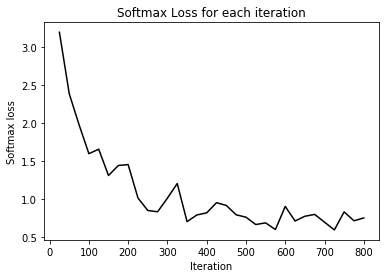

In [501]:
plt.plot(i_vals, train_loss, 'k-')
plt.title("Softmax Loss for each iteration")
plt.xlabel("Iteration")
plt.ylabel("Softmax loss")
plt.show()

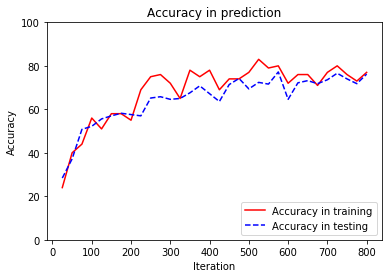

In [502]:
plt.plot(i_vals, train_acc, 'r-', label="Accuracy in training")
plt.plot(i_vals, test_acc, 'b--', label="Accuracy in testing")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim([0,100])
plt.title("Accuracy in prediction")
plt.legend(loc="lower right")
plt.show()

## Evaluation of the neural network

In [503]:
sample_idx = random.sample(range(len(images_test_28_gray)), 40)
sample_images1 = [images_test_28_gray[i] for i in sample_idx]
sample_images2 = np.expand_dims(sample_images1, 3)
sample_labels = [labels_test[i] for i in sample_idx]
prediction = sess.run([test_prediction], feed_dict={eval_input:sample_images2})[0]
prediction = [np.argmax(pred) for pred in prediction]

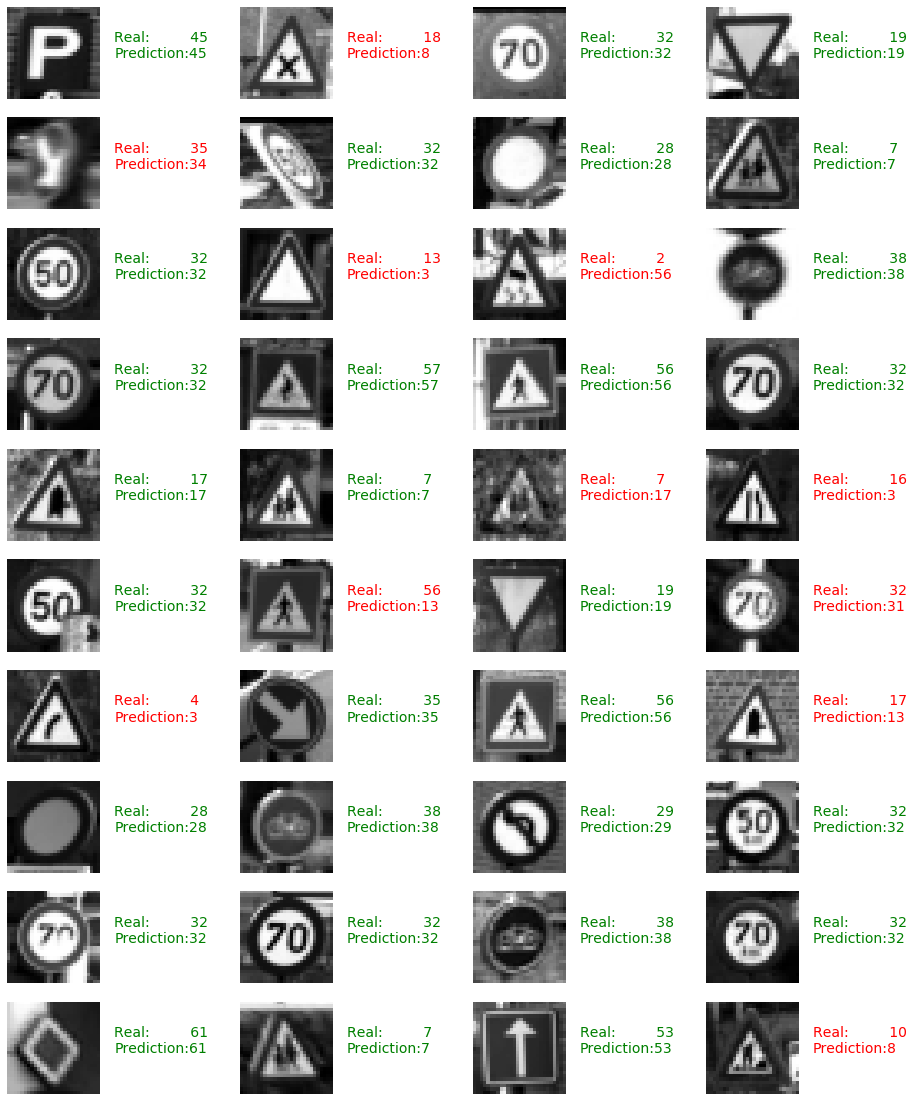

In [504]:
plt.figure(figsize=(16,20))
for i in range(len(sample_images1)):
    truth = sample_labels[i]
    predi = prediction[i]
    plt.subplot(10,4,i+1)
    plt.axis("off")
    color = "green" if truth==predi else "red"
    plt.text(32,15, "Real:         {0}\nPrediction:{1}".format(truth, predi),
            fontsize = 14, color = color)
    plt.imshow(sample_images1[i], cmap="gray")
plt.show()

### Interpretation
We can se that we are in a 80% of accuracy in training and 75% accuracy in testing, this results are very good for a simple Artificial Neural Networ, let's try to improve this results doing a convolutional neural network

## SIMPLE CONVOLUTIONAL NETWORK

- 2 Convolutional layers + ReLU + Max Pooling
- 2 Fully connected layers

In [544]:
ops.reset_default_graph()
sess = tf.Session()

In [545]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = images_train_28_gray[0].shape[0]
image_height = images_train_28_gray[0].shape[1]
target_size = max(labels_train)+1
num_chanels = 1
generations = 800
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
full_connected_size1 = 100

In [546]:
x_input_shape = (batch_size, image_width, image_height, num_chanels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (None, image_width, image_height, num_chanels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = (evaluation_size))

In [547]:
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_chanels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
                    
conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [548]:
resulting_width = image_width // (max_pool_size1*max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)

full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype = tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [549]:
def my_conv_neural_net(input_data):
    ## First layer: Conv+ReLU+Maxpool
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1, max_pool_size1,1], 
                               strides=[1, max_pool_size1, max_pool_size1,1], padding="SAME")
    ## Second layer: Conv+ReLU+Maxpool
    conv2 = tf.nn.conv2d(max_pool1, conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size2, max_pool_size2,1], 
                               strides=[1, max_pool_size2, max_pool_size2,1], padding="SAME")
    ## Flattening
    flat_output = tf.contrib.layers.flatten(max_pool2)
    ## Third Layer: fully connected
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    ## Fourth layer: fully connected
    fully_connected_2 = tf.add(tf.matmul(fully_connected_1, full2_weight), full2_bias)
    return fully_connected_2

In [550]:
model_ouput = my_conv_neural_net(x_input)
test_model_output = my_conv_neural_net(eval_input)

In [551]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_ouput, labels = y_target))

In [552]:
prediction = tf.nn.softmax(model_ouput)
test_prediction = tf.nn.softmax(test_model_output)

In [553]:
my_optim = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_step = my_optim.minimize(loss)

In [554]:
init = tf.global_variables_initializer()
sess.run(init)

In [555]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []
for i in range(generations):
    rand_idx = np.random.choice(len(images_train_28_gray), size = batch_size)
    rand_x = images_train_28_gray[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = labels_train[rand_idx]
    train_dict = {x_input:rand_x, y_target:rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(images_test_28_gray), size = evaluation_size)
        rand_x_eval = images_test_28_gray[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = labels_test[rand_idx_eval]
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}

        temp_test_preds = sess.run( test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
 
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteration {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteration 5. Train Loss: 4.129. Train Acc: 6.000. Test Acc: 4.000
Iteration 10. Train Loss: 3.885. Train Acc: 8.000. Test Acc: 2.600
Iteration 15. Train Loss: 3.798. Train Acc: 10.000. Test Acc: 3.800
Iteration 20. Train Loss: 3.601. Train Acc: 18.000. Test Acc: 14.400
Iteration 25. Train Loss: 3.626. Train Acc: 13.000. Test Acc: 19.600
Iteration 30. Train Loss: 3.521. Train Acc: 22.000. Test Acc: 20.000
Iteration 35. Train Loss: 3.447. Train Acc: 22.000. Test Acc: 11.200
Iteration 40. Train Loss: 3.337. Train Acc: 21.000. Test Acc: 12.600
Iteration 45. Train Loss: 3.286. Train Acc: 19.000. Test Acc: 20.400
Iteration 50. Train Loss: 3.301. Train Acc: 23.000. Test Acc: 28.000
Iteration 55. Train Loss: 3.225. Train Acc: 27.000. Test Acc: 32.600
Iteration 60. Train Loss: 2.933. Train Acc: 33.000. Test Acc: 29.600
Iteration 65. Train Loss: 3.084. Train Acc: 35.000. Test Acc: 28.200
Iteration 70. Train Loss: 2.715. Train Acc: 36.000. Test Acc: 31.200
Iteration 75. Train Loss: 2.618. Train A

Iteration 595. Train Loss: 0.334. Train Acc: 91.000. Test Acc: 85.400
Iteration 600. Train Loss: 0.308. Train Acc: 94.000. Test Acc: 80.000
Iteration 605. Train Loss: 0.283. Train Acc: 93.000. Test Acc: 82.400
Iteration 610. Train Loss: 0.162. Train Acc: 95.000. Test Acc: 81.600
Iteration 615. Train Loss: 0.358. Train Acc: 85.000. Test Acc: 85.000
Iteration 620. Train Loss: 0.205. Train Acc: 95.000. Test Acc: 83.400
Iteration 625. Train Loss: 0.379. Train Acc: 89.000. Test Acc: 82.800
Iteration 630. Train Loss: 0.239. Train Acc: 93.000. Test Acc: 83.800
Iteration 635. Train Loss: 0.284. Train Acc: 92.000. Test Acc: 82.800
Iteration 640. Train Loss: 0.193. Train Acc: 94.000. Test Acc: 80.800
Iteration 645. Train Loss: 0.281. Train Acc: 94.000. Test Acc: 86.200
Iteration 650. Train Loss: 0.246. Train Acc: 96.000. Test Acc: 84.400
Iteration 655. Train Loss: 0.296. Train Acc: 90.000. Test Acc: 81.000
Iteration 660. Train Loss: 0.187. Train Acc: 96.000. Test Acc: 85.000
Iteration 665. Train

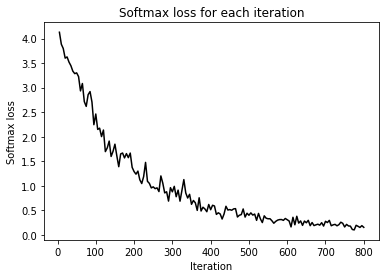

In [556]:
plt.plot(i_vals, train_loss, 'k-')
plt.title("Softmax loss for each iteration")
plt.xlabel("Iteration")
plt.ylabel("Softmax loss")
plt.show()

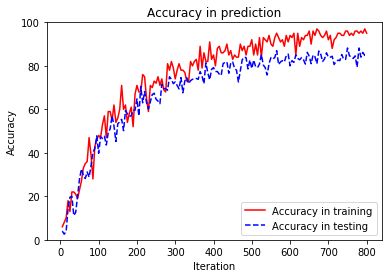

In [557]:
plt.plot(i_vals, train_acc, 'r-', label="Accuracy in training")
plt.plot(i_vals, test_acc, 'b--', label="Accuracy in testing")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim([0,100])
plt.title("Accuracy in prediction")
plt.legend(loc="lower right")
plt.show()

## Evaluation of the convolutional network

In [558]:
sample_idx = random.sample(range(len(images_test_28_gray)), 40)
sample_images1 = [images_test_28_gray[i] for i in sample_idx]
sample_images2 = np.expand_dims(sample_images1, 3)
sample_labels = [labels_test[i] for i in sample_idx]
prediction = sess.run([test_prediction], feed_dict={eval_input:sample_images2})[0]
prediction = [np.argmax(pred) for pred in prediction]

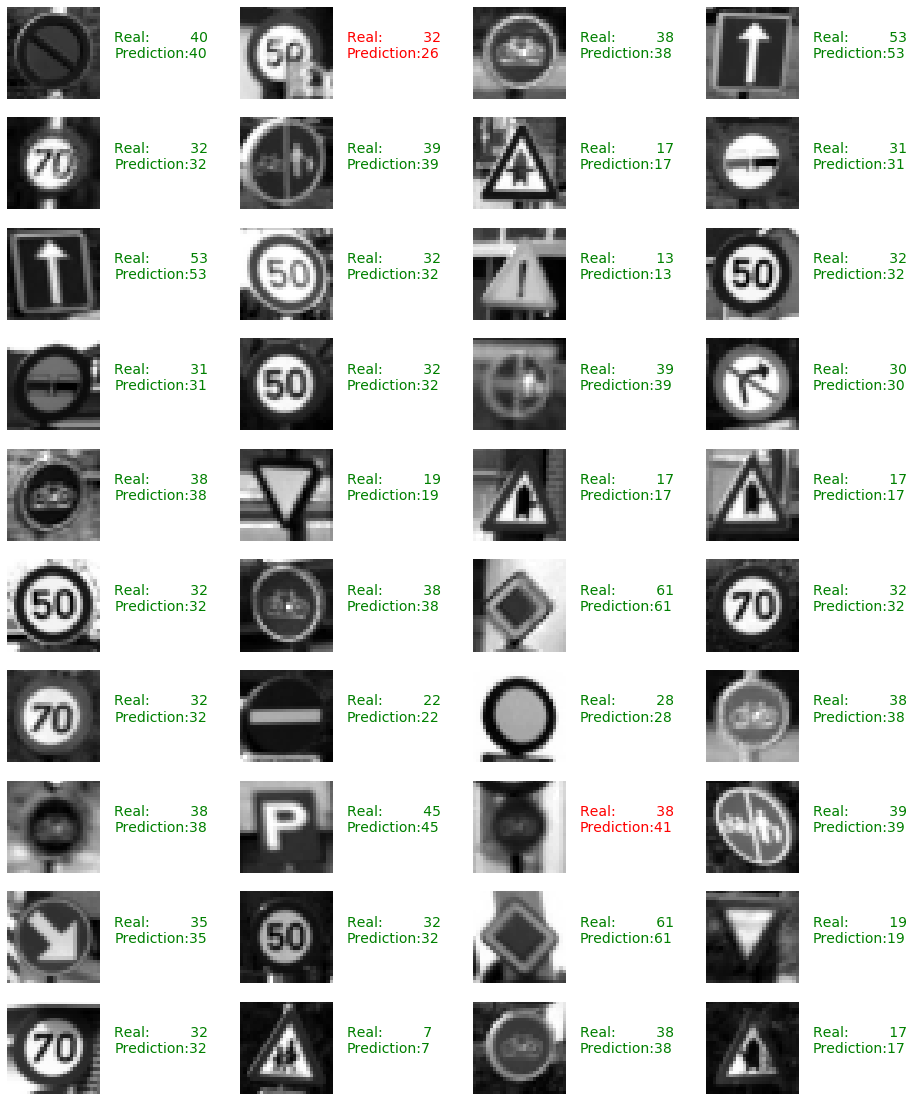

In [559]:
plt.figure(figsize=(16,20))
for i in range(len(sample_images1)):
    truth = sample_labels[i]
    predi = prediction[i]
    plt.subplot(10,4,i+1)
    plt.axis("off")
    color = "green" if truth==predi else "red"
    plt.text(32,15, "Real:         {0}\nPrediction:{1}".format(truth, predi),
            fontsize = 14, color = color)
    plt.imshow(sample_images1[i], cmap="gray")
plt.show()

### Interpretation
Our model have improve a lot, we've gone from 80% accuracy in train to 100%, and from 70% accuracy in train to 85% in test, which is very good. But we can improve even more our model, so lets do a more complex convolutional neural network 

# Model 3. Complex convolutional network

- 2 convolutional layers + ReLU + Max Pooling + Batch normalization
- 2 fully connected layers + Dropout

In [560]:
ops.reset_default_graph()
sess = tf.Session()

In [561]:
batch_size = 100
learning_rate = 0.005
evaluation_size = 500
image_width = images_train_28_gray[0].shape[0]
image_height = images_train_28_gray[0].shape[1]
target_size = max(labels_train)+1
num_chanels = 1
generations = 2500
eval_every = 5
conv1_features = 25
conv2_features = 50
max_pool_size1 = 2
max_pool_size2 = 2
full_connected_size1 = 120

In [562]:
x_input_shape = (batch_size, image_width, image_height, num_chanels)
x_input = tf.placeholder(tf.float32, shape = x_input_shape)
y_target = tf.placeholder(tf.int32, shape=(batch_size))

eval_input_shape = (None, image_width, image_height, num_chanels)
eval_input = tf.placeholder(tf.float32, shape=eval_input_shape)
eval_target = tf.placeholder(tf.float32, shape = (evaluation_size))

In [563]:
conv1_weight = tf.Variable(tf.truncated_normal([4,4,num_chanels, conv1_features], stddev=0.1, dtype=tf.float32))
conv1_bias = tf.Variable(tf.zeros([conv1_features], dtype=tf.float32))
                    
conv2_weight = tf.Variable(tf.truncated_normal([4,4,conv1_features, conv2_features], stddev=0.1, dtype=tf.float32))
conv2_bias = tf.Variable(tf.zeros([conv2_features], dtype=tf.float32))

In [564]:
resulting_width = image_width // (max_pool_size1*max_pool_size2)
resulting_height = image_height // (max_pool_size1 * max_pool_size2)

full1_input_size = resulting_width*resulting_height*conv2_features
full1_weight = tf.Variable(tf.truncated_normal([full1_input_size, full_connected_size1], stddev=0.1, dtype=tf.float32))
full1_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype = tf.float32))

full2_weight = tf.Variable(tf.truncated_normal([full_connected_size1, full_connected_size1], stddev=0.1, dtype=tf.float32))
full2_bias = tf.Variable(tf.truncated_normal([full_connected_size1], stddev=0.1, dtype=tf.float32))

full3_weight = tf.Variable(tf.truncated_normal([full_connected_size1, target_size], stddev=0.1, dtype=tf.float32))
full3_bias = tf.Variable(tf.truncated_normal([target_size], stddev=0.1, dtype=tf.float32))

In [565]:
def my_advanced_conv_neural_net(input_data):
    # First Layer: Conv+ReLU+Maxpool+BatchNormalization
    conv1 = tf.nn.conv2d(input_data, conv1_weight, strides=[1,1,1,1], padding="SAME")
    relu1 = tf.nn.relu(tf.nn.bias_add(conv1, conv1_bias))
    max_pool1 = tf.nn.max_pool(relu1, ksize=[1,max_pool_size1, max_pool_size1,1], 
                               strides=[1, max_pool_size1, max_pool_size1,1], padding="SAME")
    norm_1 = tf.nn.lrn(max_pool1, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)
    # Second layer: Conv+ReLU+Maxpool+BatchNormalization
    conv2 = tf.nn.conv2d(norm_1, conv2_weight, strides=[1,1,1,1], padding="SAME")
    relu2 = tf.nn.relu(tf.nn.bias_add(conv2, conv2_bias))
    max_pool2 = tf.nn.max_pool(relu2, ksize=[1,max_pool_size2, max_pool_size2,1], 
                               strides=[1, max_pool_size2, max_pool_size2,1], padding="SAME")
    norm_2 = tf.nn.lrn(max_pool2, depth_radius=5, bias=2.0, alpha=1e-3, beta=0.75)
    # Flattening
    flat_output = tf.contrib.layers.flatten(norm_2)
    # Third layer: Fully connected
    fully_connected_1 = tf.nn.relu(tf.add(tf.matmul(flat_output, full1_weight), full1_bias))
    fully_connected_1 = tf.nn.dropout(fully_connected_1, 0.87)
    # Fourth layer: Fully connected
    fully_connected_2 = tf.nn.relu(tf.add(tf.matmul(fully_connected_1, full2_weight), full2_bias))
    fully_connected_2 = tf.nn.dropout(fully_connected_2, 0.87)
    # Fith layer: Fully connected
    fully_connected_3 = tf.add(tf.matmul(fully_connected_2, full3_weight), full3_bias)
    return fully_connected_3

In [566]:
model_ouput = my_advanced_conv_neural_net(x_input)
test_model_output = my_advanced_conv_neural_net(eval_input)

In [567]:
loss = tf.reduce_mean(tf.nn.sparse_softmax_cross_entropy_with_logits(logits=model_ouput, labels = y_target))

In [568]:
prediction = tf.nn.softmax(model_ouput)
test_prediction = tf.nn.softmax(test_model_output)

In [569]:
my_optim = tf.train.MomentumOptimizer(learning_rate=learning_rate,momentum=0.9)
train_step = my_optim.minimize(loss)

In [570]:
init = tf.global_variables_initializer()
sess.run(init)

In [571]:
train_loss = []
train_acc = []
test_acc = []
i_vals = []
for i in range(generations):
    rand_idx = np.random.choice(len(images_train_28_gray), size = batch_size)
    rand_x = images_train_28_gray[rand_idx]
    rand_x = np.expand_dims(rand_x, 3)
    rand_y = labels_train[rand_idx]
    train_dict = {x_input:rand_x, y_target:rand_y}
    sess.run(train_step, feed_dict=train_dict)
    temp_train_loss, temp_train_preds = sess.run([loss, prediction], feed_dict=train_dict)
    temp_train_acc = get_accuracy(temp_train_preds, rand_y)
    
    if(i+1) % eval_every == 0:
        rand_idx_eval = np.random.choice(len(images_test_28_gray), size = evaluation_size)
        rand_x_eval = images_test_28_gray[rand_idx_eval]
        rand_x_eval = np.expand_dims(rand_x_eval, 3)
        rand_y_eval = labels_test[rand_idx_eval]
        test_dict = {eval_input:rand_x_eval, eval_target:rand_y_eval}

        temp_test_preds = sess.run( test_prediction, feed_dict=test_dict)
        temp_test_acc = get_accuracy(temp_test_preds, rand_y_eval)
        
        i_vals.append(i+1)
        train_loss.append(temp_train_loss)
        train_acc.append(temp_train_acc)
        test_acc.append(temp_test_acc)
 
        acc_and_loss = [(i+1),temp_train_loss, temp_train_acc, temp_test_acc]
        acc_and_loss = [np.round(x,3) for x in acc_and_loss]
        print("Iteration {}. Train Loss: {:.3f}. Train Acc: {:.3f}. Test Acc: {:.3f}".format(*acc_and_loss))

Iteration 5. Train Loss: 4.165. Train Acc: 0.000. Test Acc: 0.600
Iteration 10. Train Loss: 4.131. Train Acc: 1.000. Test Acc: 1.200
Iteration 15. Train Loss: 4.113. Train Acc: 0.000. Test Acc: 1.600
Iteration 20. Train Loss: 4.071. Train Acc: 7.000. Test Acc: 2.600
Iteration 25. Train Loss: 4.042. Train Acc: 5.000. Test Acc: 3.800
Iteration 30. Train Loss: 3.957. Train Acc: 12.000. Test Acc: 4.600
Iteration 35. Train Loss: 4.007. Train Acc: 2.000. Test Acc: 4.000
Iteration 40. Train Loss: 3.881. Train Acc: 11.000. Test Acc: 4.400
Iteration 45. Train Loss: 3.689. Train Acc: 7.000. Test Acc: 4.200
Iteration 50. Train Loss: 3.702. Train Acc: 11.000. Test Acc: 6.000
Iteration 55. Train Loss: 3.621. Train Acc: 14.000. Test Acc: 7.200
Iteration 60. Train Loss: 3.591. Train Acc: 9.000. Test Acc: 9.800
Iteration 65. Train Loss: 3.653. Train Acc: 15.000. Test Acc: 14.800
Iteration 70. Train Loss: 3.598. Train Acc: 10.000. Test Acc: 12.200
Iteration 75. Train Loss: 3.456. Train Acc: 10.000. Tes

Iteration 595. Train Loss: 1.161. Train Acc: 67.000. Test Acc: 64.200
Iteration 600. Train Loss: 0.974. Train Acc: 69.000. Test Acc: 62.200
Iteration 605. Train Loss: 0.950. Train Acc: 72.000. Test Acc: 62.600
Iteration 610. Train Loss: 1.022. Train Acc: 75.000. Test Acc: 66.200
Iteration 615. Train Loss: 1.128. Train Acc: 64.000. Test Acc: 62.800
Iteration 620. Train Loss: 1.121. Train Acc: 69.000. Test Acc: 67.000
Iteration 625. Train Loss: 0.850. Train Acc: 70.000. Test Acc: 68.200
Iteration 630. Train Loss: 1.369. Train Acc: 57.000. Test Acc: 66.800
Iteration 635. Train Loss: 1.137. Train Acc: 66.000. Test Acc: 64.800
Iteration 640. Train Loss: 0.953. Train Acc: 71.000. Test Acc: 66.000
Iteration 645. Train Loss: 1.145. Train Acc: 72.000. Test Acc: 66.600
Iteration 650. Train Loss: 0.869. Train Acc: 72.000. Test Acc: 67.000
Iteration 655. Train Loss: 1.342. Train Acc: 65.000. Test Acc: 64.400
Iteration 660. Train Loss: 1.095. Train Acc: 68.000. Test Acc: 69.800
Iteration 665. Train

Iteration 1180. Train Loss: 0.628. Train Acc: 81.000. Test Acc: 77.400
Iteration 1185. Train Loss: 0.390. Train Acc: 87.000. Test Acc: 80.600
Iteration 1190. Train Loss: 0.399. Train Acc: 89.000. Test Acc: 83.200
Iteration 1195. Train Loss: 0.420. Train Acc: 85.000. Test Acc: 81.600
Iteration 1200. Train Loss: 0.481. Train Acc: 85.000. Test Acc: 79.200
Iteration 1205. Train Loss: 0.437. Train Acc: 82.000. Test Acc: 82.000
Iteration 1210. Train Loss: 0.469. Train Acc: 82.000. Test Acc: 80.000
Iteration 1215. Train Loss: 0.403. Train Acc: 85.000. Test Acc: 77.800
Iteration 1220. Train Loss: 0.320. Train Acc: 90.000. Test Acc: 79.400
Iteration 1225. Train Loss: 0.457. Train Acc: 82.000. Test Acc: 77.200
Iteration 1230. Train Loss: 0.331. Train Acc: 89.000. Test Acc: 80.600
Iteration 1235. Train Loss: 0.419. Train Acc: 88.000. Test Acc: 78.000
Iteration 1240. Train Loss: 0.464. Train Acc: 87.000. Test Acc: 76.400
Iteration 1245. Train Loss: 0.425. Train Acc: 84.000. Test Acc: 79.800
Iterat

Iteration 1760. Train Loss: 0.194. Train Acc: 95.000. Test Acc: 84.600
Iteration 1765. Train Loss: 0.208. Train Acc: 92.000. Test Acc: 84.200
Iteration 1770. Train Loss: 0.233. Train Acc: 94.000. Test Acc: 86.600
Iteration 1775. Train Loss: 0.213. Train Acc: 93.000. Test Acc: 83.600
Iteration 1780. Train Loss: 0.224. Train Acc: 91.000. Test Acc: 84.600
Iteration 1785. Train Loss: 0.236. Train Acc: 93.000. Test Acc: 84.800
Iteration 1790. Train Loss: 0.196. Train Acc: 90.000. Test Acc: 85.000
Iteration 1795. Train Loss: 0.246. Train Acc: 94.000. Test Acc: 84.200
Iteration 1800. Train Loss: 0.170. Train Acc: 95.000. Test Acc: 84.800
Iteration 1805. Train Loss: 0.205. Train Acc: 92.000. Test Acc: 80.600
Iteration 1810. Train Loss: 0.240. Train Acc: 91.000. Test Acc: 81.000
Iteration 1815. Train Loss: 0.263. Train Acc: 92.000. Test Acc: 85.000
Iteration 1820. Train Loss: 0.155. Train Acc: 93.000. Test Acc: 85.000
Iteration 1825. Train Loss: 0.196. Train Acc: 95.000. Test Acc: 83.000
Iterat

Iteration 2340. Train Loss: 0.189. Train Acc: 94.000. Test Acc: 82.800
Iteration 2345. Train Loss: 0.174. Train Acc: 93.000. Test Acc: 82.800
Iteration 2350. Train Loss: 0.118. Train Acc: 97.000. Test Acc: 83.000
Iteration 2355. Train Loss: 0.197. Train Acc: 93.000. Test Acc: 82.400
Iteration 2360. Train Loss: 0.181. Train Acc: 94.000. Test Acc: 84.200
Iteration 2365. Train Loss: 0.149. Train Acc: 96.000. Test Acc: 86.400
Iteration 2370. Train Loss: 0.243. Train Acc: 93.000. Test Acc: 85.400
Iteration 2375. Train Loss: 0.169. Train Acc: 95.000. Test Acc: 86.600
Iteration 2380. Train Loss: 0.122. Train Acc: 96.000. Test Acc: 87.200
Iteration 2385. Train Loss: 0.100. Train Acc: 97.000. Test Acc: 86.400
Iteration 2390. Train Loss: 0.136. Train Acc: 96.000. Test Acc: 84.200
Iteration 2395. Train Loss: 0.117. Train Acc: 96.000. Test Acc: 84.800
Iteration 2400. Train Loss: 0.111. Train Acc: 95.000. Test Acc: 84.600
Iteration 2405. Train Loss: 0.192. Train Acc: 92.000. Test Acc: 87.600
Iterat

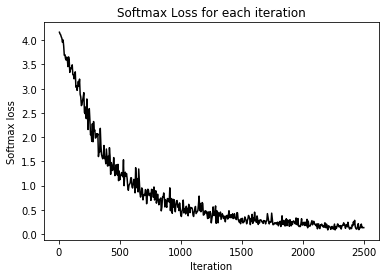

In [572]:
plt.plot(i_vals, train_loss, 'k-')
plt.title("Softmax Loss for each iteration")
plt.xlabel("Iteration")
plt.ylabel("Softmax loss")
plt.show()

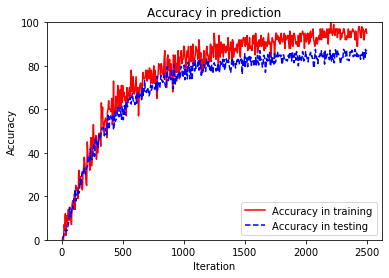

In [573]:
plt.plot(i_vals, train_acc, 'r-', label="Accuracy in training")
plt.plot(i_vals, test_acc, 'b--', label="Accuracy in testing")
plt.xlabel("Iteration")
plt.ylabel("Accuracy")
plt.ylim([0,100])
plt.title("Accuracy in prediction")
plt.legend(loc="lower right")
plt.show()

## Evaluation of the convolutional neural network

In [576]:
sample_idx = random.sample(range(len(images_test_28_gray)), 40)
sample_images1 = [images_test_28_gray[i] for i in sample_idx]
sample_images2 = np.expand_dims(sample_images1, 3)
sample_labels = [labels_test[i] for i in sample_idx]
prediction = sess.run([test_prediction], feed_dict={eval_input:sample_images2})[0]
prediction = [np.argmax(pred) for pred in prediction]

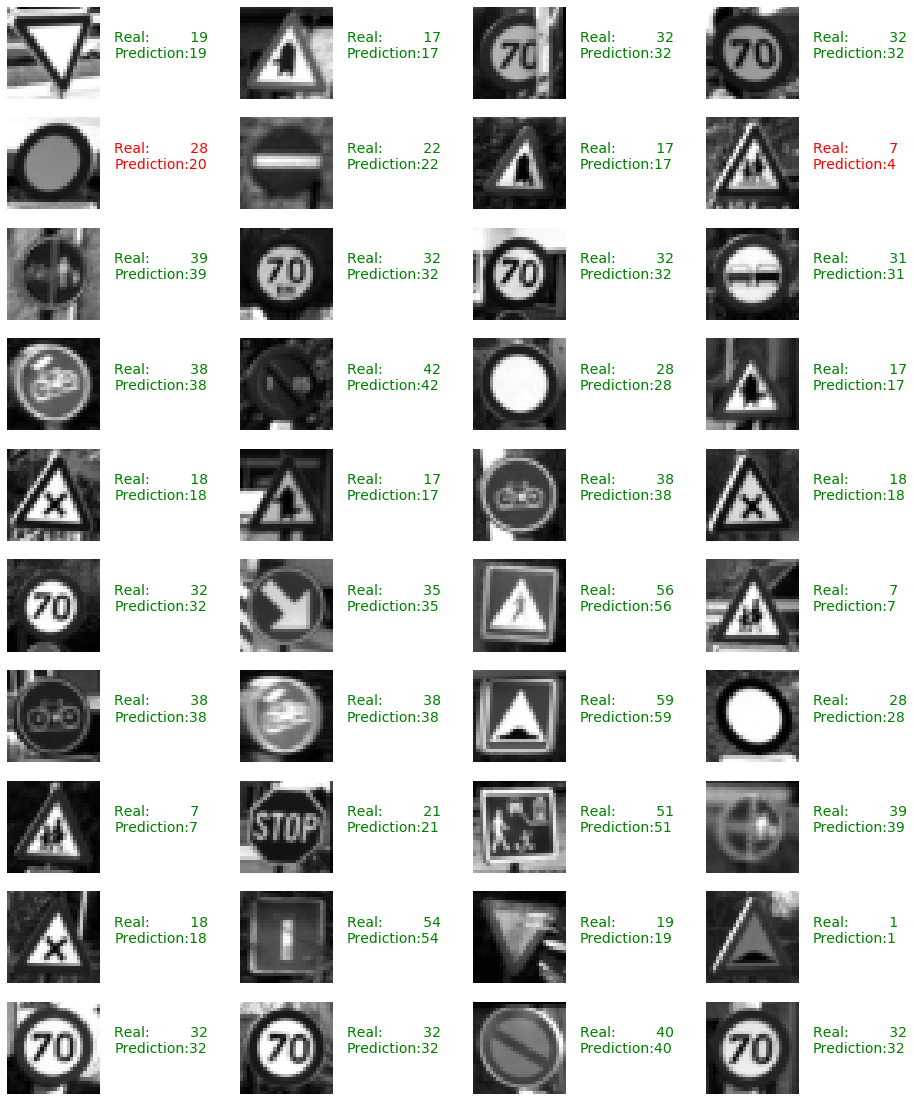

In [577]:
plt.figure(figsize=(16,20))
for i in range(len(sample_images1)):
    truth = sample_labels[i]
    predi = prediction[i]
    plt.subplot(10,4,i+1)
    plt.axis("off")
    color = "green" if truth==predi else "red"
    plt.text(32,15, "Real:         {0}\nPrediction:{1}".format(truth, predi),
            fontsize = 14, color = color)
    plt.imshow(sample_images1[i], cmap="gray")
plt.show()

We have achivement a **89% accuracy**  in test wich is a very good result. but the model is more or less the same than the last in accuracy terms. How can we improve this accuracy?
1. Obtaining more data: this will help the neural network and the imbalanced classes
2. Set better hyperparamenters: for example the learning rate, there are techniques to predict a good learning rate. Or the convolutional and fully connected layers
3. Clean the dataset: there are a few images with very very low quality almost impossible to recognize, if we make a better pre-processing we will obtain better results
4. Use a pretrained model doing Transfer Learning and Fine Tunning